In [ ]:
import os
import pickle
import torch
import sys

from PIL import Image
from skimage.io import imread
from skimage.transform import resize
from matplotlib import pyplot as plt
from tabulate import tabulate

tablefmt = "latex_raw"

In [ ]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

# fix the path
original_path = os.getcwd()
sys.path.append(os.path.join('.', '..'))
sys.path.append('/content/drive/My Drive/Deep_Learning_Project12/')
os.chdir(sys.path[-1])

Mounted at /content/drive


# Upsampling class (NaturalImageDataSet)


In [ ]:
from tqdm import tqdm
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

class NaturalImageDataset(Dataset):
  def __init__(self, data, augment = False, load_img=True, dictator="features_label"):

    # dictator = 'features_label'    # What variable we use to upsample to match
    # upsample if augment
    if augment:
      sample_count = {}
      up_sampler = np.unique(data[dictator])
      for f in up_sampler:
          sample_count[f] = np.count_nonzero(data[dictator] == f)

      maxcount = np.max(list(sample_count.values()))
      for f in up_sampler:
          gapnum = maxcount - sample_count[f]
          temp_df = data.iloc[np.random.choice(np.where(data[dictator] == f)[0], size = gapnum)]
          data = data.append(temp_df, ignore_index = True)
      

    self.dataframe = data
    self.imgage_path = data["image_path"].values
    self.labels = data["ts"].values
    self.features = data["features"].values

    # transform image
    if augment:
      self.transform = transforms.Compose([
                                  transforms.Resize(256),
                                  transforms.CenterCrop(224),
                                  transforms.ToTensor(),
                                  transforms.RandomHorizontalFlip(p = 0.5),
                                  transforms.RandomVerticalFlip(p=0.5),
                                  transforms.ColorJitter(brightness = 0.1, contrast = 0.1),
                                  transforms.RandomAffine(degrees = 50, translate = (0.1, 0.1), scale = (0.9, 1.1)),
                                  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                              ])
    else:
      self.transform = transforms.Compose([
                                  transforms.Resize(256),
                                  transforms.CenterCrop(224),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                              ])


    if load_img:
      self.images = [self.transform(Image.open(img_path)) for img_path in tqdm(data["image_path"])]

  def __len__(self):
    return (len(self.images))

  def __getitem__(self, i):
    image = self.images[i]
    label = self.labels[i]
    feature = self.features[i]
    return image, torch.tensor(label, dtype=torch.long), torch.tensor(feature, dtype=torch.long)

# Import Data and Wrangling

In [ ]:
import numpy as np
import pandas as pd

data_files = os.listdir("Files")
  
labels = pd.read_csv("Files/dermx_labels.csv")
labels["area"] = labels["area"].fillna(value = "NA")
labels = pd.get_dummies(labels, columns = ["area"])
labels["image_path"] = [os.path.join(os.getcwd(),"Files", "images", f"{x}.jpeg") for x in labels["image_id"]]
labels.drop(columns = "Unnamed: 0", inplace = True)
labels["open_comedo"] = (labels["open_comedo"] > 0).astype(int)

features_target = pd.read_csv("Files/diseases_characteristics.csv")
features_target.rename(columns={"Unnamed: 0":"disease"},inplace=True)

# create on_hot for diagnosis and get features
one_hot = pd.get_dummies(labels["diagnosis"])
one_hot_encoding = [list(x) for x in one_hot.values]

labels["ts"] = one_hot_encoding

# get features as multi hot
features_touse = labels.columns[2:14]
labels["features"] = labels.loc[:, features_touse].values.tolist()

# map feature sequences to value
features_map = {}
for idx, feat in enumerate(labels["features"].apply(tuple).unique()):
  features_map[str(feat)] = idx

labels["features_label"] = labels["features"].apply(tuple).apply(str).map(features_map)


# get domain
domain = pd.read_csv("Files/diseases_characteristics.csv")
domain.rename(columns={"Unnamed: 0":"diagnosis"},inplace=True)
domain["area_NA"] = 0 # Fix for area_NA
domain = pd.get_dummies(domain, columns = ["area"])
same_sort = labels.columns[1:14]
domain = domain[same_sort]  # same sorting

domain_one_hot = pd.get_dummies(domain["diagnosis"])

domain_one_hot_encoding = [list(x) for x in domain_one_hot.values]
domain["ts"] = domain_one_hot_encoding
feature_cols = domain.columns[1:13]
domain["features"] = domain.loc[:,feature_cols].values.tolist()

# add domain features (domain knowledge) to dataframe
tf = []
for i, row in labels.iterrows():
  disease = row["diagnosis"]
  true_features = domain.loc[domain.diagnosis == disease].features.tolist()[0]
  tf.append(true_features)
labels["domain_features"] = tf 

domain = domain.sort_values(by="diagnosis").reset_index(drop=True)

data = labels.copy()
up_data = NaturalImageDataset(data,augment=True,load_img=False)
upsampled_data = up_data.dataframe

# Functions

In [ ]:
def add_domain(df: pd.DataFrame):
  domain = pd.read_csv("Files/diseases_characteristics.csv")
  domain.rename(columns={"Unnamed: 0":"diagnosis"},inplace=True)
  domain["area_NA"] = 0 # Fix for area_NA
  domain = pd.get_dummies(domain, columns = ["area"])
  same_sort = df.columns[1:14]
  domain = domain[same_sort]  # same sorting

  domain_one_hot = pd.get_dummies(domain["diagnosis"])

  domain_one_hot_encoding = [list(x) for x in domain_one_hot.values]
  domain["ts"] = domain_one_hot_encoding
  feature_cols = domain.columns[1:13]
  domain["features"] = domain.loc[:,feature_cols].values.tolist()

  # add domain features (domain knowledge) to dataframe
  tf = []
  for i, row in df.iterrows():
    disease = row["diagnosis"]
    true_features = domain.loc[domain.diagnosis == disease].features.tolist()[0]
    tf.append(true_features)
  df["domain_features"] = tf 

  return df

def fix_label(label: str):
  if "area_" in label:
    label = label.replace("area_","")
  new_str = label.replace("_","\n")
  return new_str

from HelperFunctions.project_utils import Tracker
from sklearn.utils import class_weight


def add_no_match(df: pd.DataFrame):
  
  unique_data = [list(x) for x in set(tuple(x) for x in df.domain_features)]

  app = []
  for i, row in df.iterrows():
    for x in unique_data:
      tmp_row = row.copy()
      if tmp_row["domain_features"] == x:
        pass
      else:
        tmp_row["diagnosis"] = "no_match"
        tmp_row["domain_features"] = x
        app.append(tmp_row)

  # Create new data frame
  updated_df=df.append(app,ignore_index=True)
  
  # Update targets "ts"
  updated_df.drop(columns="ts")
  new_dummies = pd.get_dummies(updated_df["diagnosis"])
  new_dummies = [list(x) for x in new_dummies.values]
  updated_df["ts"] = new_dummies

  return updated_df

def unique_lists(data: list):
  return [list(x) for x in set(tuple(x) for x in data)]

def map_domain_knowledge(df: pd.DataFrame):
  keys = df.diagnosis.unique().tolist()
  map = dict()
  for k in keys:
    map[k] = df.loc[data["diagnosis"] == k].domain_features.tolist()[0]
  return map

def plt_tracker(tracker: Tracker, num_epoch):
    plt.figure(figsize=(14,8))
    epoch_ticks = range(0,num_epoch + 1, 5)

    # loss
    plt.subplot(1,2,1)
    plt.plot(tracker.train_iter, tracker.train_loss, label='Training loss')
    plt.plot(tracker.val_iter, tracker.val_loss, label='Validation loss')
    plt.title("Loss")
    plt.ylabel("Loss"), plt.xlabel("Epoch")
    plt.xticks(epoch_ticks)
    plt.legend()
    plt.grid()

    # acc
    plt.subplot(1,2,2)
    plt.plot(tracker.train_iter, tracker.train_acc, label='Training accuracy')
    plt.plot(tracker.val_iter, tracker.val_acc, label='Validation accuracy')
    plt.title("Accuracy")
    plt.ylabel("Accuracy"), plt.xlabel("Epoch")
    plt.xticks(epoch_ticks)
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()


def calc_multiclass_weights(df: pd.DataFrame, device):
  
  cls = sorted(df.diagnosis.unique())
  y = df.diagnosis.to_list()
  csw = class_weight.compute_class_weight('balanced', classes = cls, y = y)
  class_weights = torch.tensor(csw,dtype=torch.float).to(device)

  return class_weights

def feature_intersect(domain, features):
    dom_feat = np.asarray(domain)
    curr_feat = np.asarray(features)
    
    ones=np.intersect1d(np.where(dom_feat==1), np.where(curr_feat==1))
    intersect = np.zeros(len(dom_feat),dtype=int)
    intersect[ones] = 1

    return intersect

# colors

In [ ]:
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt

cmap = [matplotlib.colors.to_rgb(c) for c in plt.rcParams['axes.prop_cycle'].by_key()['color']]

# Plot datset distribution

# Summarize k_fold



In [ ]:
from HelperFunctions.project_utils import KFoldResult, plot_tracker
from sklearn.metrics import classification_report

# features
runs_labels = []
runs_features = []
runs_MTL = []

k = 5
for i in range(k):
  fname=f"K_fold/LabelsNet_FINAL_kfold_{i}.json"
  run = KFoldResult(fname)
  runs_labels.append(run)

  fname=f"K_fold/Features_FINAL_kfold_{i}.json"
  run = KFoldResult(fname,isMTL=False)
  runs_features.append(run)

  fname=f"K_fold/MTLNet_FINAL_kfold_{i}.json"
  run = KFoldResult(fname)
  runs_MTL.append(run)
  

labels_acc = []
features_acc = []
MTL_labels_acc = []
MTL_features_acc = []
for run_l, run_f, run_MTL in zip(runs_labels, runs_features, runs_MTL):
  labels_acc.append(run_l.get_labels_accuracy())
  features_acc.append(run_f.get_features_accuracy())
  MTL_labels_acc.append(run_MTL.get_labels_accuracy())
  MTL_features_acc.append(run_MTL.get_features_accuracy())
  

In [ ]:

tab_f1 = {
    "k"           :list(range(1, 5+1)) + ["Mean", "Std"],
    "Features Net": [f"{v:.3f}" for v in features_acc] + [f"{np.mean(features_acc):.3f}", f"{np.std(features_acc):.3f}"],
    "MTL Net (features)"     : [f"{v:.3f}" for v in MTL_features_acc] + [f"{np.mean(MTL_features_acc):.3f}", f"{np.std(MTL_features_acc):.3f}"],
    "Disease Net"  : [f"{v:.3f}" for v in labels_acc] + [f"{np.mean(labels_acc):.3f}", f"{np.std(labels_acc):.3f}"],
    "MTL Net (disease)"     : [f"{v:.3f}" for v in MTL_labels_acc] + [f"{np.mean(MTL_labels_acc):.3f}", f"{np.std(MTL_labels_acc):.3f}"],
}


print(tabulate(tab_f1, headers = "keys"))
# print(tabulate(tab_f1, headers = "keys", tablefmt=tablefmt))

\begin{tabular}{lrrrr}
\hline
 k    &   Features Net &   MTL Net (features) &   Labels Net &   MTL Net (labels) \\
\hline
 1    &          0.756 &                0.751 &        0.715 &              0.75  \\
 2    &          0.749 &                0.79  &        0.845 &              0.721 \\
 3    &          0.688 &                0.697 &        0.807 &              0.73  \\
 4    &          0.743 &                0.776 &        0.765 &              0.844 \\
 5    &          0.729 &                0.75  &        0.702 &              0.762 \\
 Mean &          0.733 &                0.753 &        0.767 &              0.761 \\
 Std  &          0.024 &                0.032 &        0.054 &              0.044 \\
\hline
\end{tabular}


In [ ]:
metrics = {
      "Precision": [],
      "Recall": [],
      "F1 score": [],
      "Support": []
}

total_support = np.zeros(len(features_touse))
for i, run in enumerate(runs_MTL):
  pred = run.features_preds
  prob = run.features_probs
  targ = run.features_targets

  run_dict = classification_report(targ,pred, zero_division=0, target_names = features_touse, output_dict = True, digits = 2)
  run_precision = []
  run_recall = []
  run_f1 = []
  run_support = []
  tmp = []
  for key in features_touse:
    item = run_dict[key] 
    run_precision.append(item["precision"])
    run_recall.append(item["recall"])
    run_f1.append(item["f1-score"])
    run_support.append(item["support"])

    
  metrics["Precision"].append(run_precision)
  metrics["Recall"].append(run_recall)
  metrics["F1 score"].append(run_f1)
  metrics["Support"].append(run_support)
  total_support += run_support
tmp.append(metrics["Support"])
metrics["Weights"] = [support / total_support for support in metrics["Support"]]

metrics_avg = {
      "Precision": sum([p*w for p, w in zip(metrics["Precision"], metrics["Weights"])]),
      "Recall": sum([r*w for r, w in zip(metrics["Recall"], metrics["Weights"])]),
      "F1 score": sum([f*w for f, w in zip(metrics["F1 score"], metrics["Weights"])])
    }

tab = {
    "Feature":  features_touse,
    "Precision": [f"{v:.3f}" for v in metrics_avg['Precision']],
    "Recall": [f"{v:.3f}" for v in metrics_avg['Recall']],
    "F1 score": [f"{v:.3f}" for v in metrics_avg['F1 score']],
}

print(tabulate(tab, headers = "keys"))
# print(tabulate(tab, headers = "keys", tablefmt=tablefmt))

\begin{tabular}{lrrr}
\hline
 Feature                 &   Precision &   Recall &   F1 score \\
\hline
 scale                   &       0.817 &    0.842 &      0.827 \\
 plaque                  &       0.873 &    0.838 &      0.853 \\
 pustule                 &       0.791 &    0.847 &      0.816 \\
 patch                   &       0.784 &    0.805 &      0.793 \\
 papule                  &       0.808 &    0.713 &      0.756 \\
 dermatoglyph_disruption &       0.614 &    0.75  &      0.669 \\
 open_comedo             &       0.606 &    0.889 &      0.716 \\
 area_NA                 &       0.392 &    0.525 &      0.447 \\
 area_acral_distribution &       0.735 &    0.884 &      0.8   \\
 area_exposed_areas      &       0.664 &    0.525 &      0.577 \\
 area_extensor_sites     &       0.602 &    0.635 &      0.603 \\
 area_seborrheic_region  &       0.789 &    0.915 &      0.839 \\
\hline
\end{tabular}


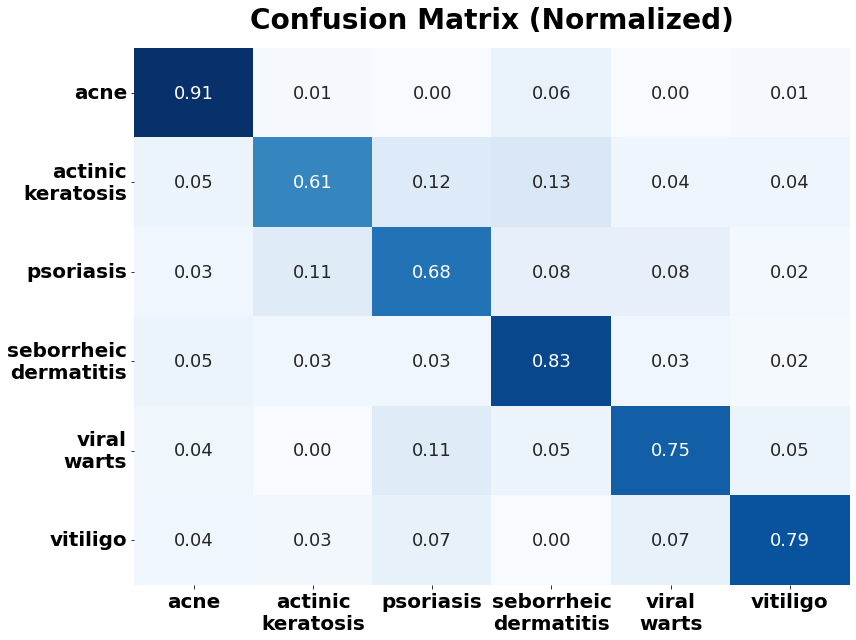

In [ ]:
header_size = 28
text_size = 20

from sklearn.metrics import confusion_matrix

def plot_conf(conf,target_labels):
  df_cm = pd.DataFrame(conf, index = [i for i in target_labels],
                              columns = [i for i in target_labels])
  plt.figure(figsize = (12,9))
  ax = sns.heatmap(df_cm, annot=True, cmap="Blues", cbar=False,
                   annot_kws={"size": 18},fmt='.2f')
  ax.set_xticklabels([fix_label(lab) for lab in target_labels], fontsize=text_size,weight="bold")
  ax.set_yticklabels([fix_label(lab) for lab in target_labels], fontsize=text_size,weight="bold", rotation = 0)
  plt.title("Confusion Matrix (Normalized)",fontsize=header_size,weight="bold",pad=20)
  
  plt.tight_layout()
  # plt.savefig("Figures/Kfold_CFM.eps",format="eps",dpi=1000, bbox_inches='tight',pad_inches=0)
  plt.show()

  

num_classes = len(np.unique(runs_MTL[0].labels_targets))
overall_conf = np.zeros(shape=(num_classes, num_classes, len(runs_MTL)))

for i, run in enumerate(runs_MTL):
  conf = confusion_matrix(run.labels_targets, run.labels_preds, normalize="true")
  overall_conf[:,:,i] = conf

plot_conf(overall_conf.mean(axis=2), sorted(data.diagnosis.unique().tolist()))

